In [1]:
import os, psutil
import gc

import numpy as np
import pandas as pd
import scipy as sci
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import sklearn
sklearn.set_config(transform_output="pandas")

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB 

from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_validate,cross_val_score,train_test_split, KFold, GridSearchCV, LearningCurveDisplay, ValidationCurveDisplay
from sklearn.metrics import classification_report, accuracy_score, log_loss, roc_auc_score, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn import ensemble,metrics,model_selection,neighbors,preprocessing, svm, tree
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, TargetEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

import lightgbm as lgb
from lightgbm import LGBMClassifier

from statsmodels.graphics.mosaicplot import mosaic

from time import time
import warnings

import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
%%time
# taken from https://www.kaggle.com/ryanholbrook/getting-started-september-2021-tabular-playground

def cpu_stats():
    pid = os.getpid()
    py = psutil.Process(pid)
    memory_use = py.memory_info()[0] / 2. ** 30
    return 'memory GB:' + str(np.round(memory_use, 2))

def score(X, y, model, cv, scoring = {"AUC_OVR_Weighted": "roc_auc_ovr_weighted","AUC_OVO_Weighted": "roc_auc_ovo_weighted", "Accuracy": "accuracy"}):
    scores = cross_validate(
        model, X, y, scoring=scoring, cv=cv, return_train_score=True
    )
    scores = pd.DataFrame(scores).T
    return scores.assign(
        mean = lambda x: x.mean(axis=1),
        std = lambda x: x.std(axis=1),
    )
print('Function built')

Function built
CPU times: total: 0 ns
Wall time: 0 ns


In [3]:
%%time

## from: https://www.kaggle.com/bextuychiev/how-to-work-w-million-row-datasets-like-a-pro
def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                        c_min > np.finfo(np.float16).min
                        and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                        c_min > np.finfo(np.float32).min
                        and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

CPU times: total: 0 ns
Wall time: 0 ns


In [4]:
# Modified from HW 5 Q2 Part a.
def train_and_evaluate_classifier(name, clf, X_train, y_train, X_test, y_test, cv=5, debug=False, learning_curve=False, confusion=False, supress_outputs=True):
  print(name)
    
  t0 = time()
  # Fit your classifier on the training set
  ### START CODE ###
  clf.fit(X_train, y_train)
  ### END CODE ###
  if supress_outputs == False:
      print("training time", round(time()-t0, 3), "s")

  t0 = time()
  y_train_pred = clf.predict(X_train)
  y_test_pred = clf.predict(X_test)
  if supress_outputs == False:
      print("predict time", round(time()-t0, 3), "s")

  if supress_outputs == False:
    print("Confusion matrix: ")
  # Print the confusion matrix computed from the test set (1 line of code only)
  ### START CODE ###
  #print(confusion_matrix(y_test, y_pred))
  # ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train)
  if confusion == True:
      ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
      plt.show()
  ### END CODE ###


  ### START CODE ###
  y_train_pred_proba = clf.predict_proba(X_train)
  y_test_pred_proba = clf.predict_proba(X_test)
    
  if debug == True:
      print(y_test_pred_proba)

  train_acc_score = accuracy_score(y_train, y_train_pred)
  test_acc_score = accuracy_score(y_test, y_test_pred)

  train_auc_score_ovo = roc_auc_score(y_train, y_train_pred_proba, multi_class='ovo')  
  train_auc_score_ovr = roc_auc_score(y_train, y_train_pred_proba, multi_class='ovr')
    
  test_auc_score_ovo = roc_auc_score(y_test, y_test_pred_proba, multi_class='ovo')  
  test_auc_score_ovr = roc_auc_score(y_test, y_test_pred_proba, multi_class='ovr')
  ### END CODE ###
    
  if supress_outputs == False:
      print("TRAIN - Accuracy: {}, AUC_ROC_OVO: {}, AUC_ROC_OVR: {}".format(train_acc_score, train_auc_score_ovo, train_auc_score_ovr))
      print("TEST - Accuracy: {}, AUC_ROC_OVO: {}, AUC_ROC_OVR: {}".format(test_acc_score, test_auc_score_ovo, test_auc_score_ovr))

  # Display Learning curve
  if learning_curve == True:
      LearningCurveDisplay.from_estimator(clf, X_train, y_train, scoring='accuracy')
  #RocCurveDisplay.from_estimator(clf, X_test, y_test)

  train_results = [train_acc_score, train_auc_score_ovo, train_auc_score_ovr]
  test_results = [test_acc_score, test_auc_score_ovo, test_auc_score_ovr]
  return train_results, test_results

In [5]:
df = pd.read_csv('dataset/train.csv')
df = df.drop(columns='id')

count    20758.000000
mean        30.241842
std          8.333932
min         12.868541
25%         24.088223
50%         29.384757
75%         37.011168
max         54.997991
Name: BMI, dtype: float64

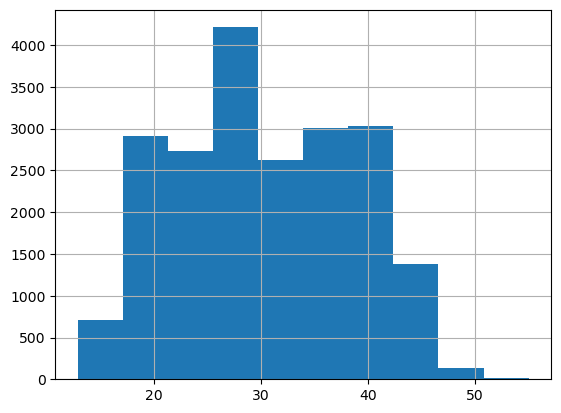

In [6]:
df['BMI'] = df['Weight'] / (df['Height'] ** 2)
df['BMI'].hist()
df['BMI'].describe()

In [7]:
df['Adult'] = df['Age'] >= 20 

# from https://www.dataquest.io/blog/tutorial-add-column-pandas-dataframe-based-on-if-else-condition/
# create a list of our conditions
conditions = [
    (df['Adult'] == False),
    (df['Adult'] == True) & (df['BMI'] < 18.5),
    (df['Adult'] == True) & (df['BMI'] >= 18.5) & (df['BMI'] < 25),
    (df['Adult'] == True) & (df['BMI'] >= 25) & (df['BMI'] < 30),
    (df['Adult'] == True) & (df['BMI'] >= 30) & (df['BMI'] < 35),
    (df['Adult'] == True) & (df['BMI'] >= 35) & (df['BMI'] < 40),
    (df['Adult'] == True) & (df['BMI'] >= 40)
    ]

# create a list of the values we want to assign for each condition
values = ['N/A', 'underweight', 'healthy', 'overweight', 'obseity class 1', 'obseity class 2', 'obseity class 3']

# create a new column and use np.select to assign values to it using our lists as arguments
df['BMI Predictions'] = np.select(conditions, values)

In [8]:
df

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI,Adult,BMI Predictions
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II,28.259565,True,overweight
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight,23.422091,False,N/A
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight,17.126706,False,N/A
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III,44.855798,True,obseity class 3
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II,25.599151,True,overweight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,Male,25.137087,1.766626,114.187096,yes,yes,2.919584,3.000000,Sometimes,no,2.151809,no,1.330519,0.196680,Sometimes,Public_Transportation,Obesity_Type_II,36.587084,True,obseity class 2
20754,Male,18.000000,1.710000,50.000000,no,yes,3.000000,4.000000,Frequently,no,1.000000,no,2.000000,1.000000,Sometimes,Public_Transportation,Insufficient_Weight,17.099278,False,N/A
20755,Male,20.101026,1.819557,105.580491,yes,yes,2.407817,3.000000,Sometimes,no,2.000000,no,1.158040,1.198439,no,Public_Transportation,Obesity_Type_II,31.889841,True,obseity class 1
20756,Male,33.852953,1.700000,83.520113,yes,yes,2.671238,1.971472,Sometimes,no,2.144838,no,0.000000,0.973834,no,Automobile,Overweight_Level_II,28.899693,True,overweight


In [9]:
df_lean = reduce_memory_usage(df, verbose=True)
# test = reduce_memory_usage(test, verbose=True)
print(cpu_stats())
print('Memory reduced')

Mem. usage decreased to 1.96 Mb (35.3% reduction)
memory GB:0.23
Memory reduced


features obtained


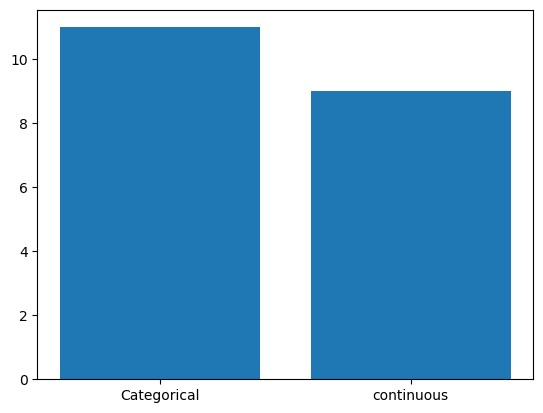

CPU times: total: 109 ms
Wall time: 83 ms


In [10]:
%%time
features=[]
cat_features=[]
cont_features=[]
for feature in df_lean.columns:
    features.append(feature)
    if df_lean.dtypes[feature] in ['int8', 'object', 'bool']:
        cat_features.append(feature)
    if df_lean.dtypes[feature]=='float16':
        cont_features.append(feature)
    #print(test.dtypes[feature])
print('features obtained')

plt.bar([1,2],[len(cat_features),len(cont_features)])
plt.xticks([1,2],('Categorical','continuous'))
plt.show()

In [11]:
%%time
# Get shape of data
print('*'*40, '\nHow much data was imported?')
print('*'*40)
print('Training data :', df_lean.shape)
# print('Test data :', test.shape)
print('*'*40,"\n")

# missing data
print('*'*40,'\nHow much data is missing?')
print('*'*40)
training_missing_val_count_by_column = (df_lean.isnull().values.sum())
# test_missing_val_count_by_column = (test.isnull().values.sum())
print('Missing training data :  {:.2f} ({:.1f})%'.format (training_missing_val_count_by_column,training_missing_val_count_by_column/df_lean.shape[0]))
# print('Missing test data :  {:.2f} ({:.1f})%'.format (test_missing_val_count_by_column,test_missing_val_count_by_column/test.shape[0]))
print('*'*40,"\n")

# categorical data
print('*'*40,'\nFeature types?')
print('*'*40)
print('Categorical features : ', (len(cat_features)))
print('Continuous features : ', (len(cont_features)))
print('*'*40,'\n')

# get info
print('*'*40,'\nInfo on datasets')
print('*'*40)
print(df_lean.info(),'\n')
# print(test.info(),'\n')
print('*'*40)

print('\noverview complete')
del training_missing_val_count_by_column #,test_missing_val_count_by_column

**************************************** 
How much data was imported?
****************************************
Training data : (20758, 20)
**************************************** 

**************************************** 
How much data is missing?
****************************************
Missing training data :  0.00 (0.0)%
**************************************** 

**************************************** 
Feature types?
****************************************
Categorical features :  11
Continuous features :  9
**************************************** 

**************************************** 
Info on datasets
****************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          20758 non-null  object 
 1   Age                             20758 n

In [12]:
y = df['NObeyesdad']
X = df.drop(columns='NObeyesdad')

y_lean = df_lean['NObeyesdad']
X_lean = df_lean.drop(columns='NObeyesdad')

In [13]:
X

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,BMI,Adult,BMI Predictions
0,Male,24.437500,1.700195,81.68750,yes,yes,2.000000,2.982422,Sometimes,no,2.763672,no,0.000000,0.976562,Sometimes,Public_Transportation,28.265625,True,overweight
1,Female,18.000000,1.559570,57.00000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,23.421875,False,N/A
2,Female,18.000000,1.711914,50.15625,yes,yes,1.880859,1.412109,Sometimes,no,1.910156,no,0.866211,1.673828,no,Public_Transportation,17.125000,False,N/A
3,Female,20.953125,1.710938,131.25000,yes,yes,3.000000,3.000000,Sometimes,no,1.673828,no,1.467773,0.780273,Sometimes,Public_Transportation,44.843750,True,obseity class 3
4,Male,31.640625,1.914062,93.81250,yes,yes,2.679688,1.971680,Sometimes,no,1.979492,no,1.967773,0.931641,Sometimes,Public_Transportation,25.593750,True,overweight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,Male,25.140625,1.766602,114.18750,yes,yes,2.919922,3.000000,Sometimes,no,2.152344,no,1.330078,0.196655,Sometimes,Public_Transportation,36.593750,True,obseity class 2
20754,Male,18.000000,1.709961,50.00000,no,yes,3.000000,4.000000,Frequently,no,1.000000,no,2.000000,1.000000,Sometimes,Public_Transportation,17.093750,False,N/A
20755,Male,20.093750,1.819336,105.56250,yes,yes,2.408203,3.000000,Sometimes,no,2.000000,no,1.158203,1.198242,no,Public_Transportation,31.890625,True,obseity class 1
20756,Male,33.843750,1.700195,83.50000,yes,yes,2.671875,1.971680,Sometimes,no,2.144531,no,0.000000,0.973633,no,Automobile,28.906250,True,overweight


In [14]:
y

0        Overweight_Level_II
1              Normal_Weight
2        Insufficient_Weight
3           Obesity_Type_III
4        Overweight_Level_II
                ...         
20753        Obesity_Type_II
20754    Insufficient_Weight
20755        Obesity_Type_II
20756    Overweight_Level_II
20757        Obesity_Type_II
Name: NObeyesdad, Length: 20758, dtype: object

In [15]:
cat_features.remove('NObeyesdad')
cat_features

['Gender',
 'family_history_with_overweight',
 'FAVC',
 'CAEC',
 'SMOKE',
 'SCC',
 'CALC',
 'MTRANS',
 'Adult',
 'BMI Predictions']

In [16]:
ordinalCT = OrdinalEncoder()

ordinalCatOnlyCT = ColumnTransformer(
        [
            ("numerical", "passthrough", cont_features),
            ("categorical", OrdinalEncoder(), cat_features),
        ]
    )

ordinalCatStandardCT = ColumnTransformer(
        [
            ("numerical", StandardScaler(), cont_features),
            ("categorical", OrdinalEncoder(), cat_features),
        ]
    )

ordinalCatRobustCT = ColumnTransformer(
        [
            ("numerical", RobustScaler(), cont_features),
            ("categorical", OrdinalEncoder(), cat_features),
        ]
    )

# Removed due to memory issues
# oneHotCT = OneHotEncoder() 


oneHotCatOnlyCT = ColumnTransformer(
        [
            ("numerical", "passthrough", cont_features),
            ("categorical", OneHotEncoder(drop='if_binary', sparse_output=False), cat_features),
        ]
    )

oneHotCatStandardCT = ColumnTransformer(
        [
            ("numerical", StandardScaler(), cont_features),
            ("categorical", OneHotEncoder(drop='if_binary', sparse_output=False), cat_features),
        ]
    )

oneHotCatRobustCT = ColumnTransformer(
        [
            ("numerical", RobustScaler(), cont_features),
            ("categorical", OneHotEncoder(drop='if_binary', sparse_output=False), cat_features),
        ]
    )

CTs = [ordinalCT, ordinalCatOnlyCT, ordinalCatStandardCT, ordinalCatRobustCT, 
       # oneHotCT, 
       oneHotCatOnlyCT, oneHotCatStandardCT, oneHotCatRobustCT]
preprocessed = ["(Ordinal)", "(Ordinal Categorical Only - No Scaling)", "(Ordinal Categorical Only - Standard Scaler)", "(Ordinal Categorical Only - Robust Scaler)",
                # "(One Hot)", 
                "(One Hot Categorical Only - No Scaling)", "(One Hot Categorical Only - Standard Scaler)", "(One Hot Categorical Only - Robust Scaler)"]

if len(CTs) != len(preprocessed):
    print("NUMBER OF TRANSFORMERS != NUMBER OF PREPROCESSED DATASETS") 

In [17]:
X.flags

<Flags(allows_duplicate_labels=True)>

In [18]:
# TEST WITH DIFFERENT ENCODERS: ORDINAL, ONE-HOT, TARGET
lean = True
if lean == True:
    X = X_lean
    y = y_lean

X_s = []
for CT in CTs:
    X_s.append(CT.fit_transform(X, y))

X_train = [None] * len(X_s)
X_test = [None] * len(X_s)
y_train = [None] * len(X_s)
y_test = [None] * len(X_s)

for i, X in enumerate(X_s):
    X_train[i], X_test[i], y_train[i], y_test[i] = train_test_split(X, y, test_size=1/3, random_state=42)


In [19]:
# pipes[1]['columntransformer'].get_params()['categorical'].categories_

In [20]:
# Model 1 - Decision Tree
test = []
models = []
for i, name in enumerate(preprocessed):
    model = DecisionTreeClassifier()
    train_results, test_results = train_and_evaluate_classifier(f"Decision Tree {name}", model, X_train[i], y_train[i], X_test[i], y_test[i], confusion=False)
    test.append(test_results[0])
    models.append(model)
    print()
    
test = np.array(test)
loc_best_test = np.argmax(test)
print(f"Best Preprocessing: {preprocessed[loc_best_test]} - Test Accuracy: {test[loc_best_test]}")
best_model = models[loc_best_test]
dataset = X_train[loc_best_test]

Decision Tree (Ordinal)

Decision Tree (Ordinal Categorical Only - No Scaling)

Decision Tree (Ordinal Categorical Only - Standard Scaler)

Decision Tree (Ordinal Categorical Only - Robust Scaler)

Decision Tree (One Hot Categorical Only - No Scaling)

Decision Tree (One Hot Categorical Only - Standard Scaler)

Decision Tree (One Hot Categorical Only - Robust Scaler)

Best Preprocessing: (Ordinal Categorical Only - No Scaling) - Test Accuracy: 0.8463872832369942


(13838, 19, 7)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


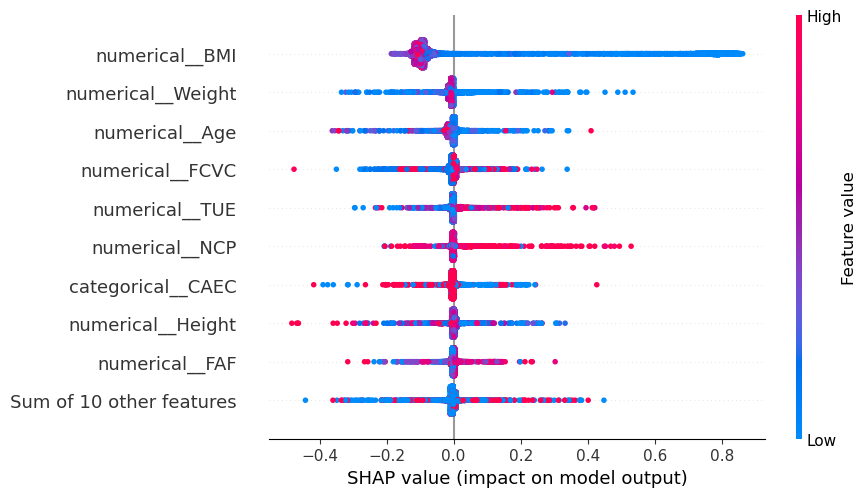

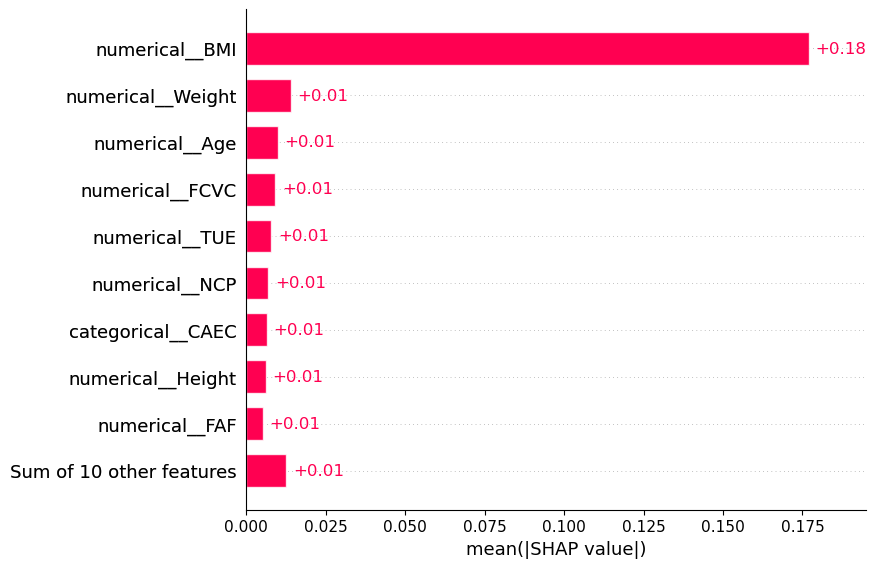

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


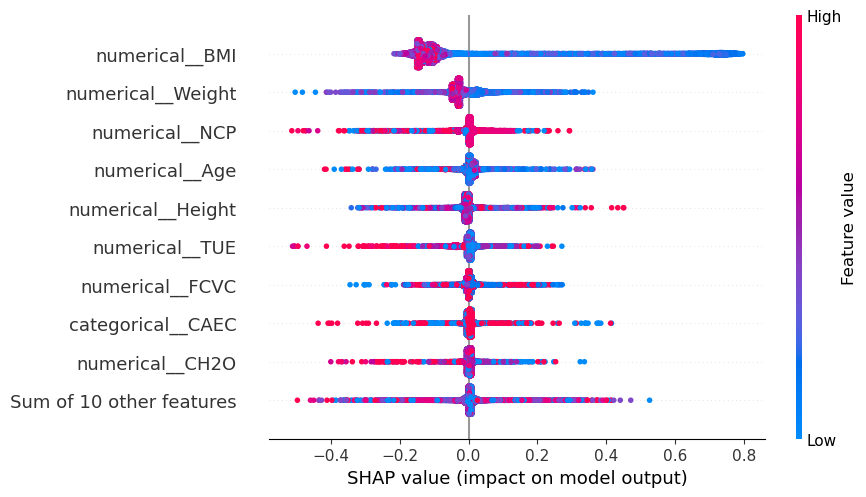

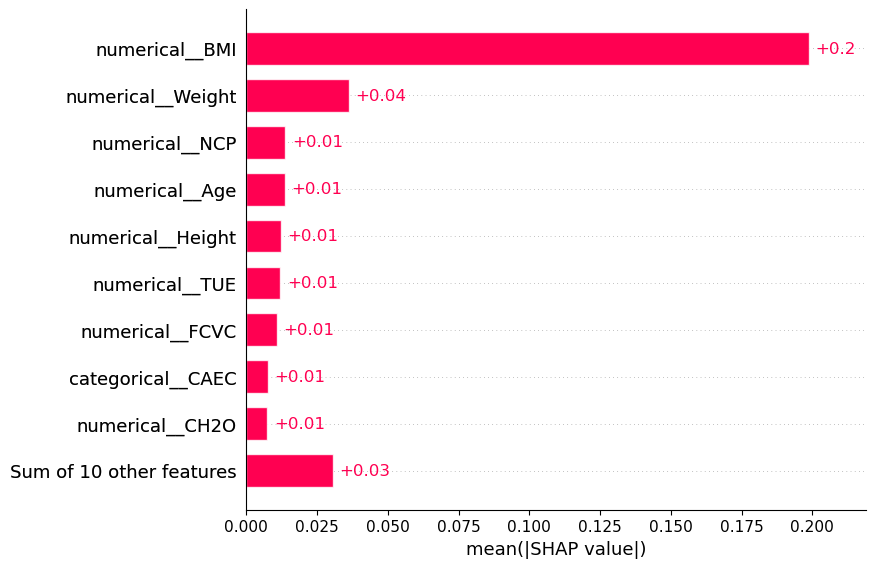

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


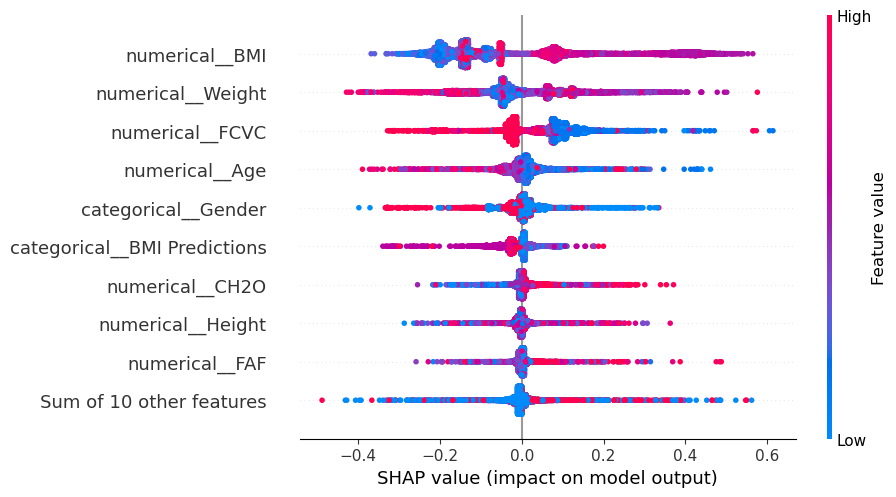

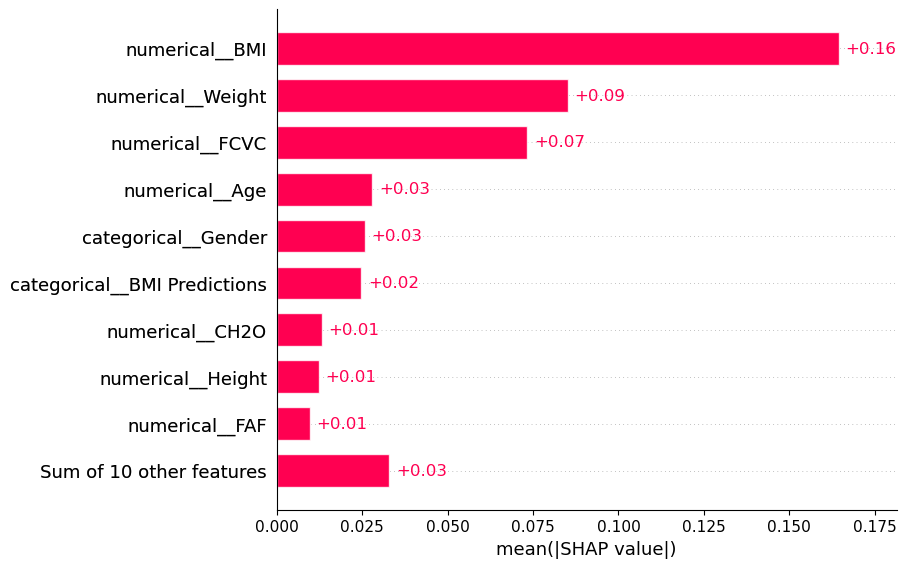

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


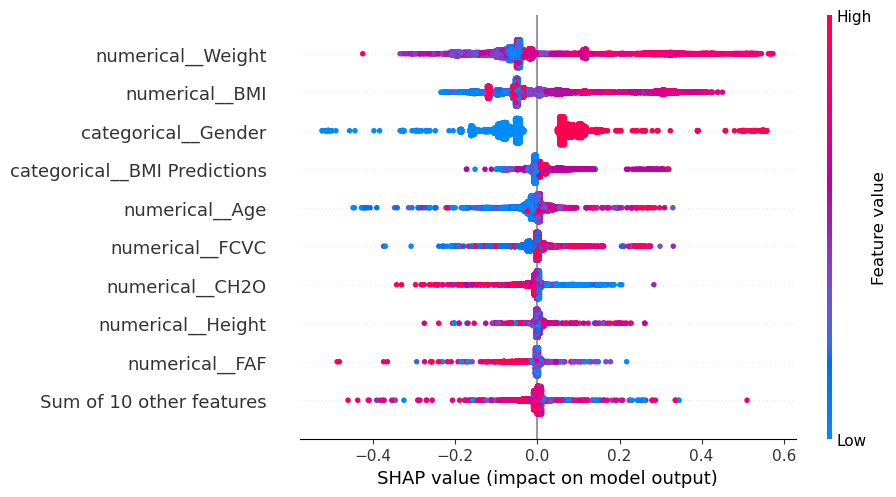

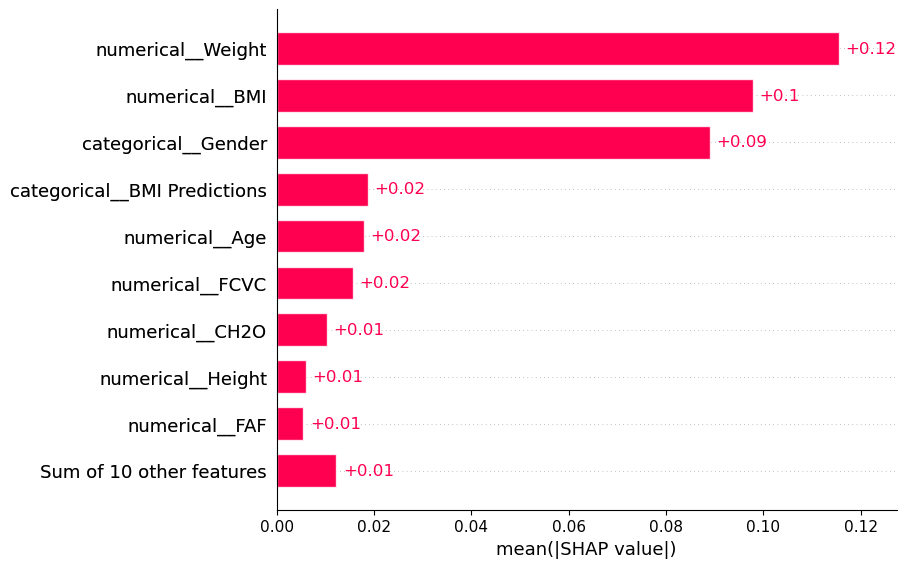

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


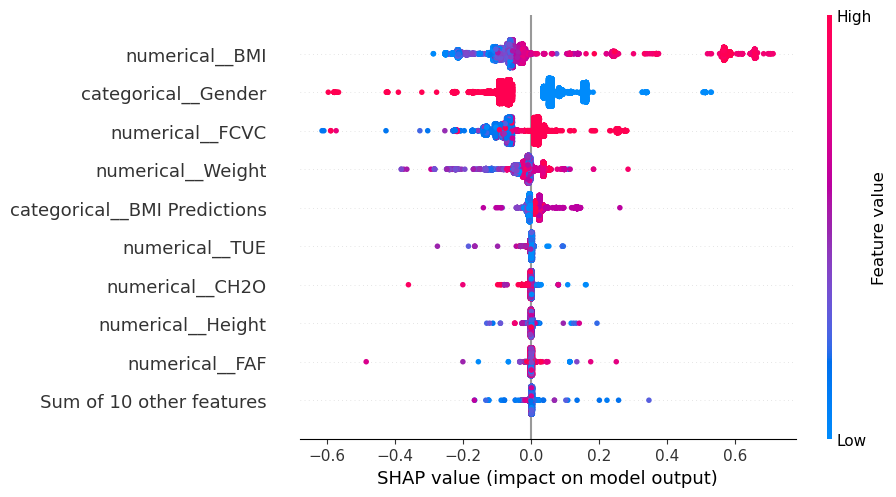

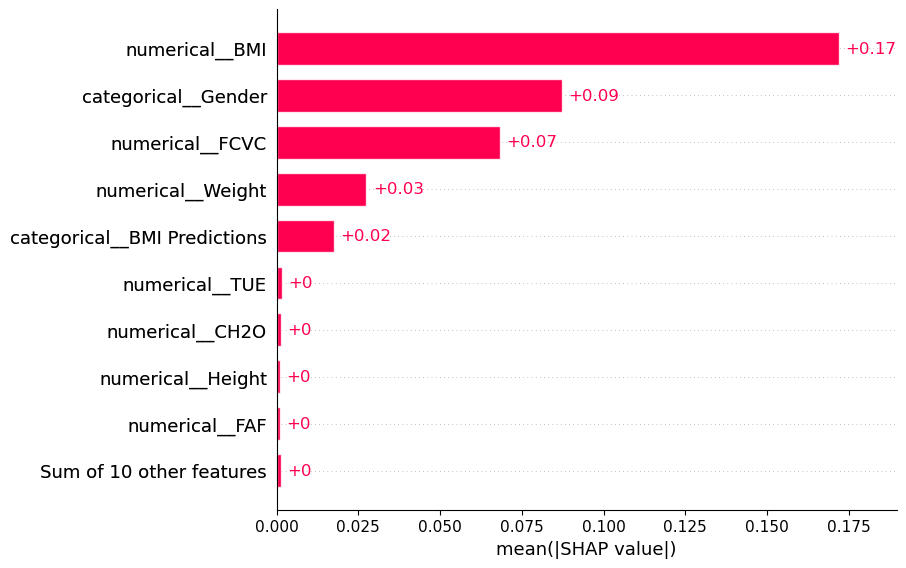

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


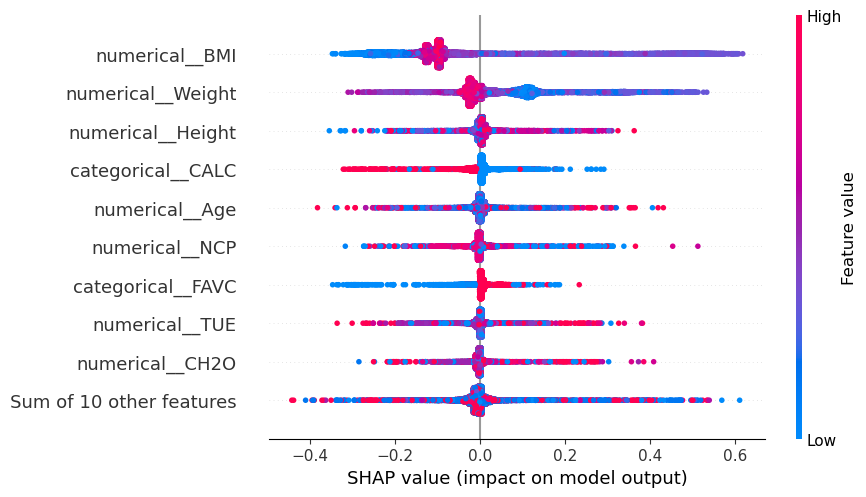

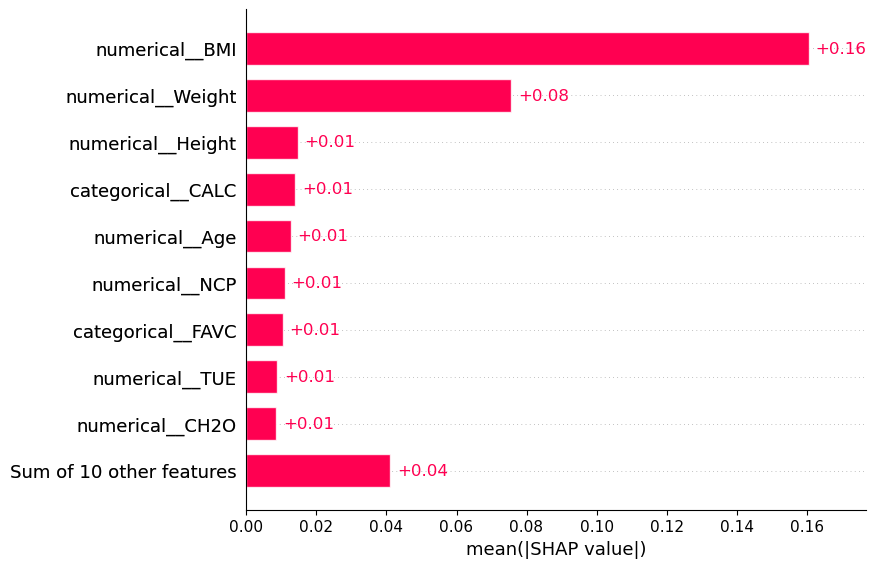

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


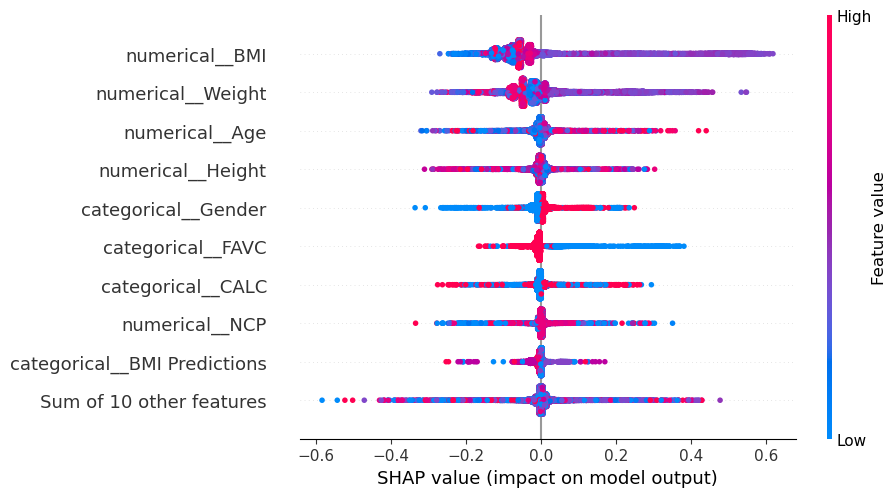

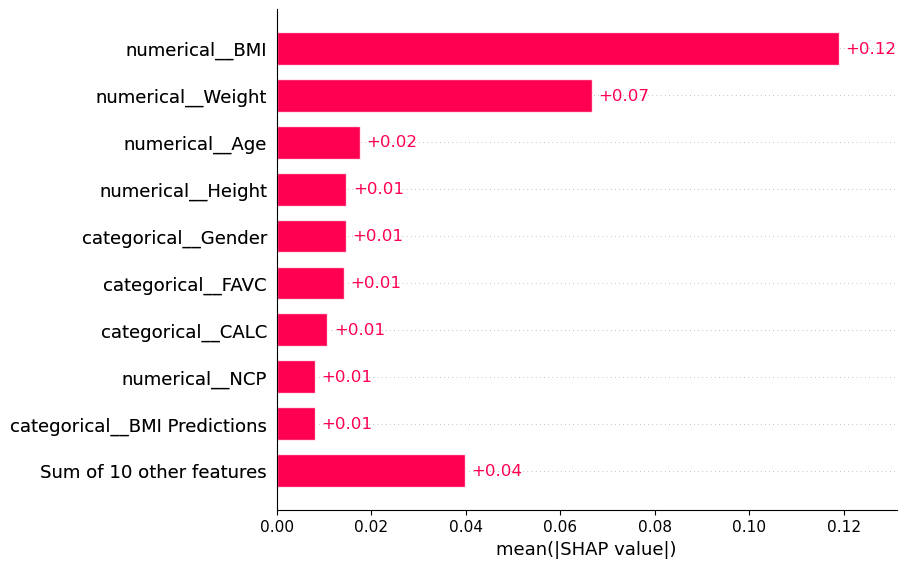

In [21]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(best_model)
shap_values = explainer(dataset)
print(shap_values.shape)

for i in range(shap_values.shape[2]):
    # summarize the effects of all the features
    shap.plots.beeswarm(shap_values[:, :, i])
    
    shap.plots.bar(shap_values[:, :, i])

In [22]:
# Model 2a - Logistic Regression
test = []
models = []
for i, name in enumerate(preprocessed):
    model = LogisticRegression(max_iter = 5000)
    train_results, test_results = train_and_evaluate_classifier(f"Logistic Regression {name}", model, X_train[i], y_train[i], X_test[i], y_test[i], confusion=False)
    test.append(test_results[0])
    models.append(model)
    print()
    
test = np.array(test)
loc_best_test = np.argmax(test)
print(f"Best Preprocessing: {preprocessed[loc_best_test]} - Test Accuracy: {test[loc_best_test]}")
best_model = models[loc_best_test]
dataset = X_train[loc_best_test]

Logistic Regression (Ordinal)


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Logistic Regression (Ordinal Categorical Only - No Scaling)


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Logistic Regression (Ordinal Categorical Only - Standard Scaler)

Logistic Regression (Ordinal Categorical Only - Robust Scaler)

Logistic Regression (One Hot Categorical Only - No Scaling)


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Logistic Regression (One Hot Categorical Only - Standard Scaler)

Logistic Regression (One Hot Categorical Only - Robust Scaler)

Best Preprocessing: (One Hot Categorical Only - Standard Scaler) - Test Accuracy: 0.86878612716763


(13838, 34, 7)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


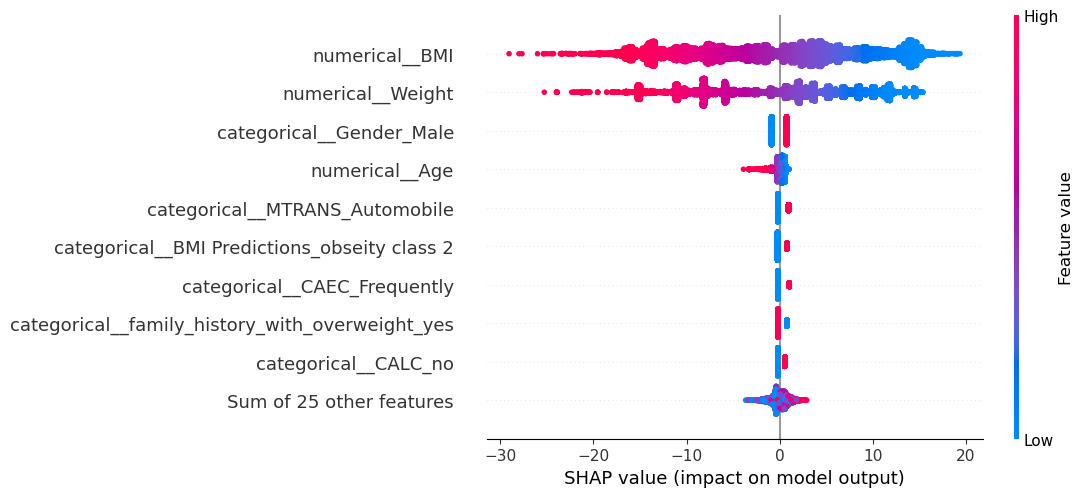

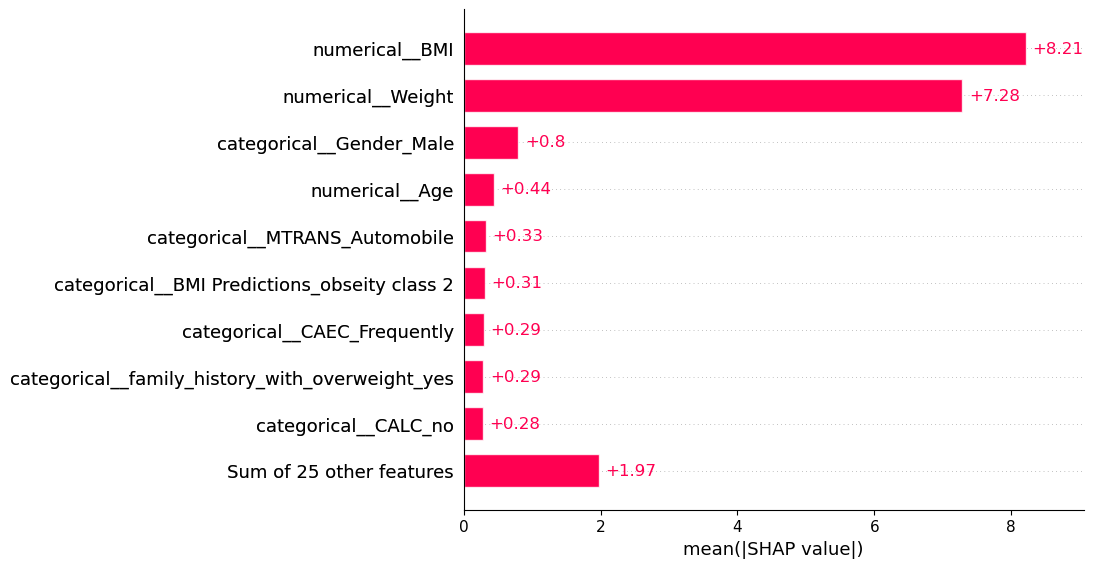

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


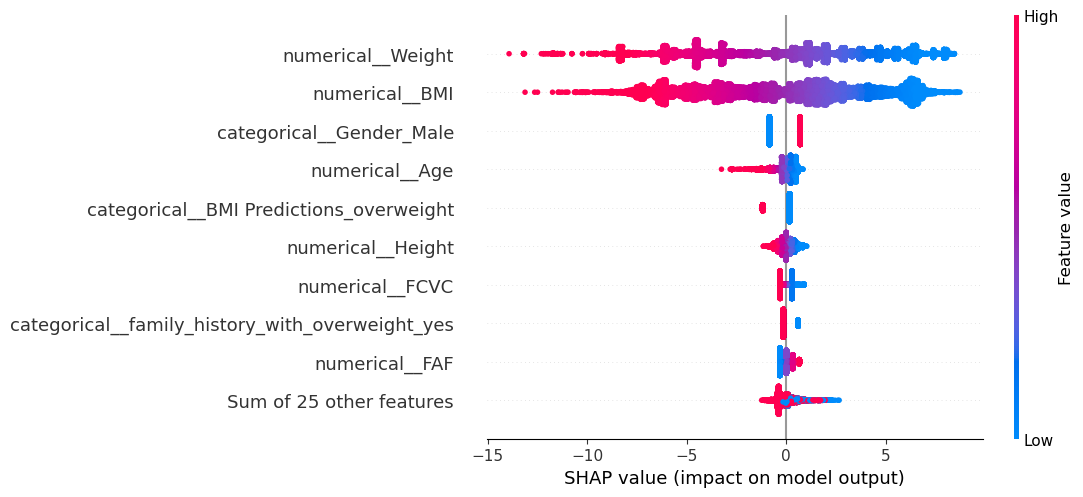

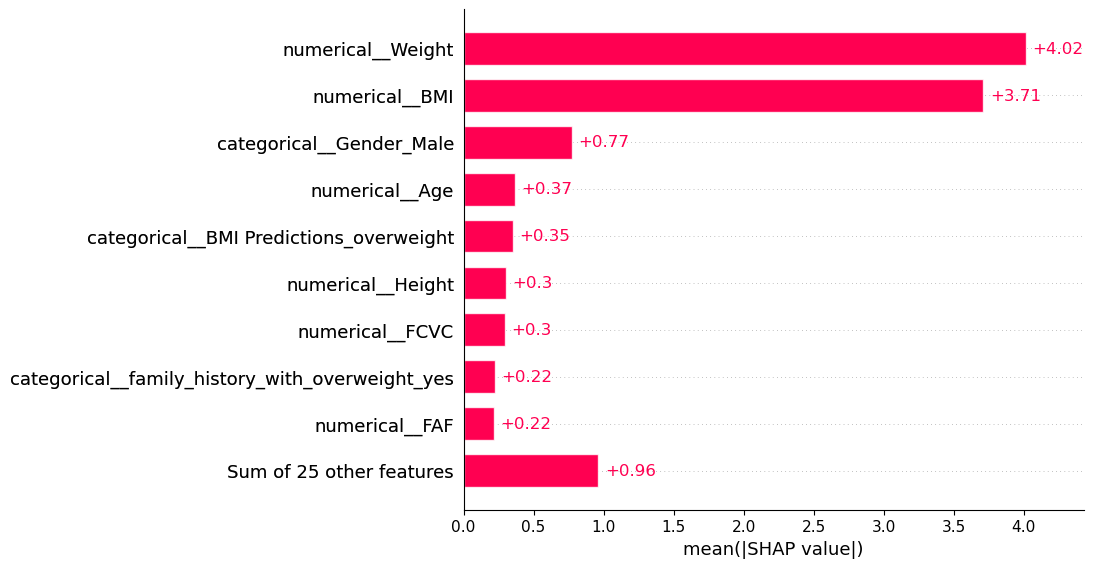

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


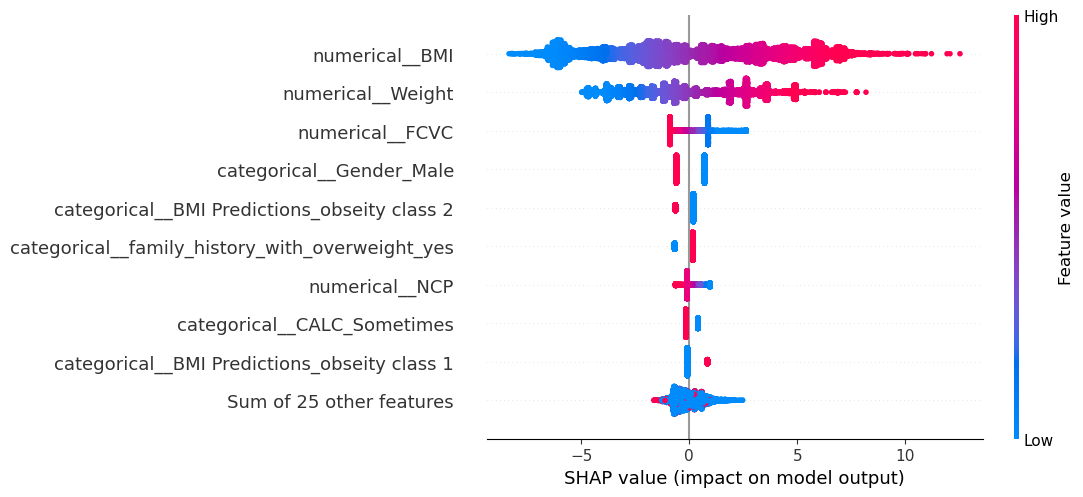

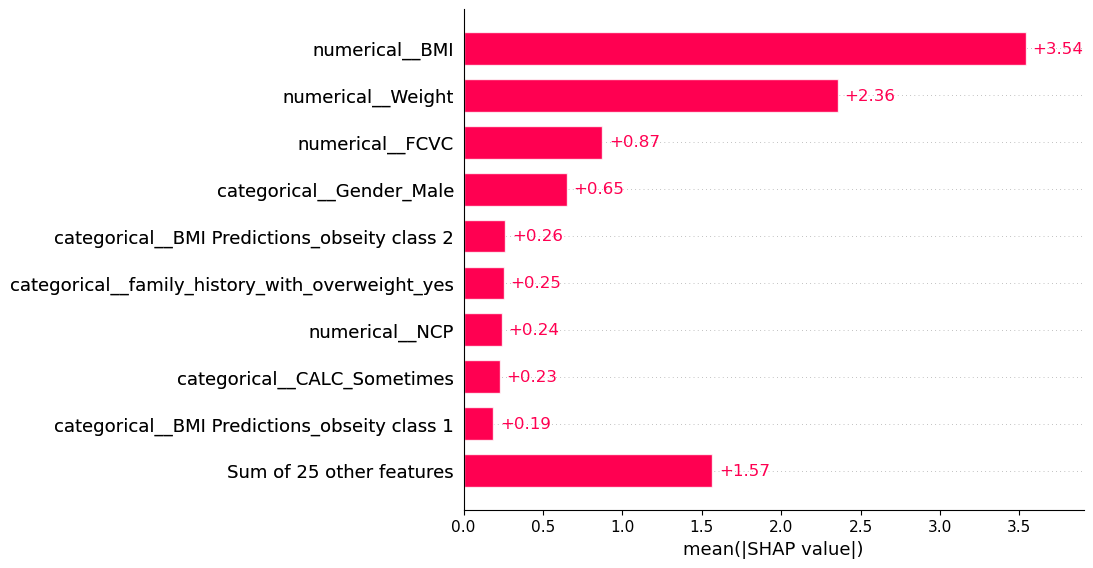

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


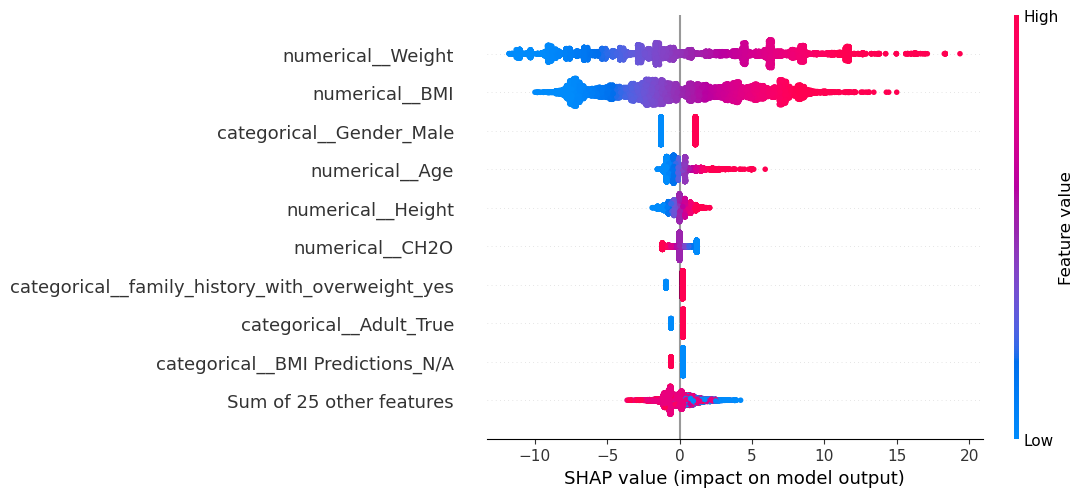

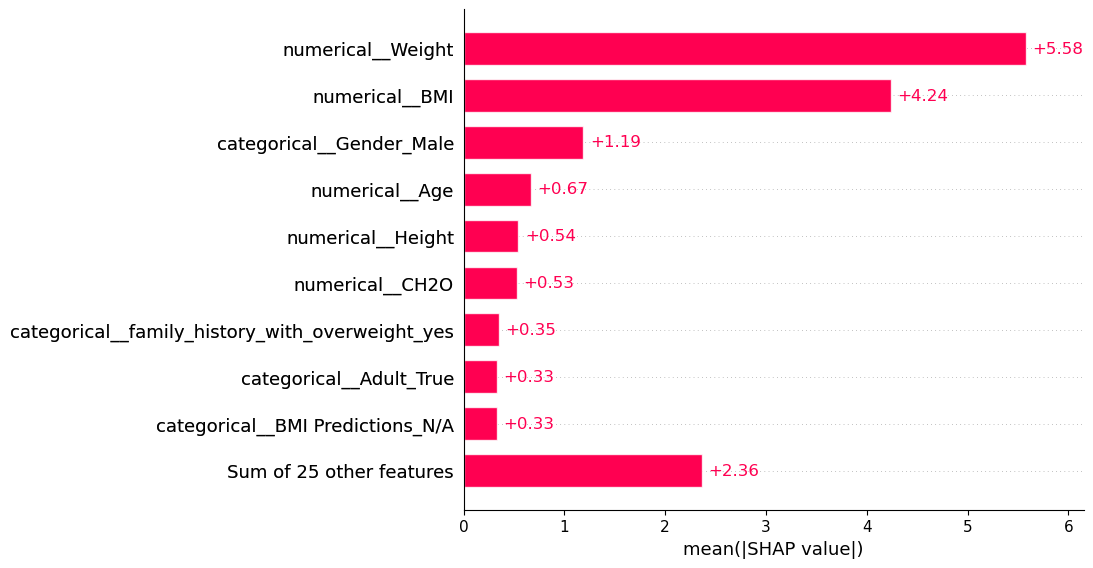

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


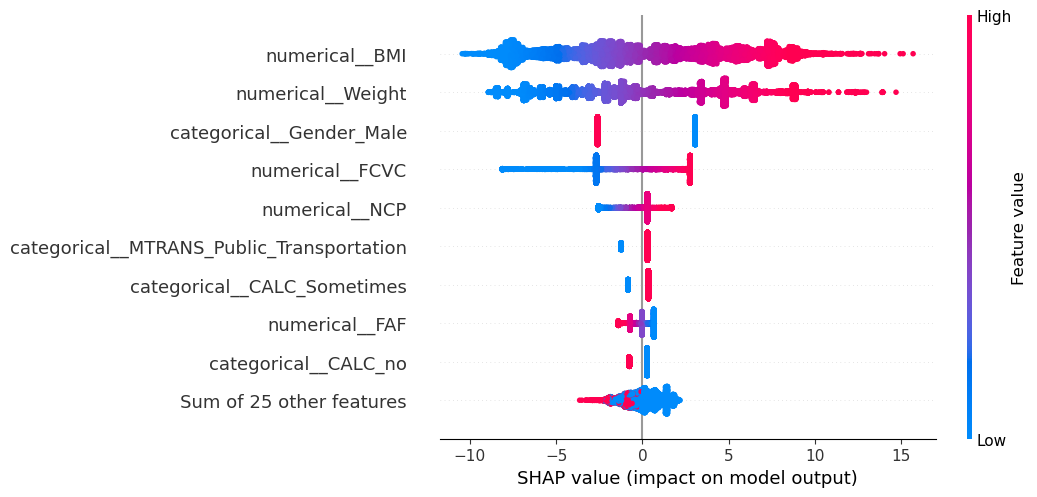

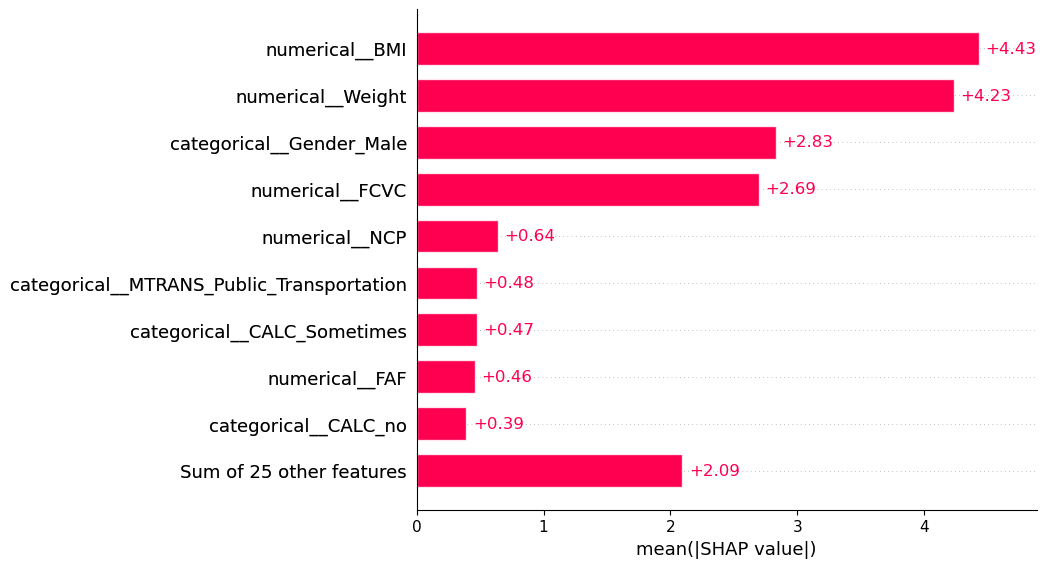

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


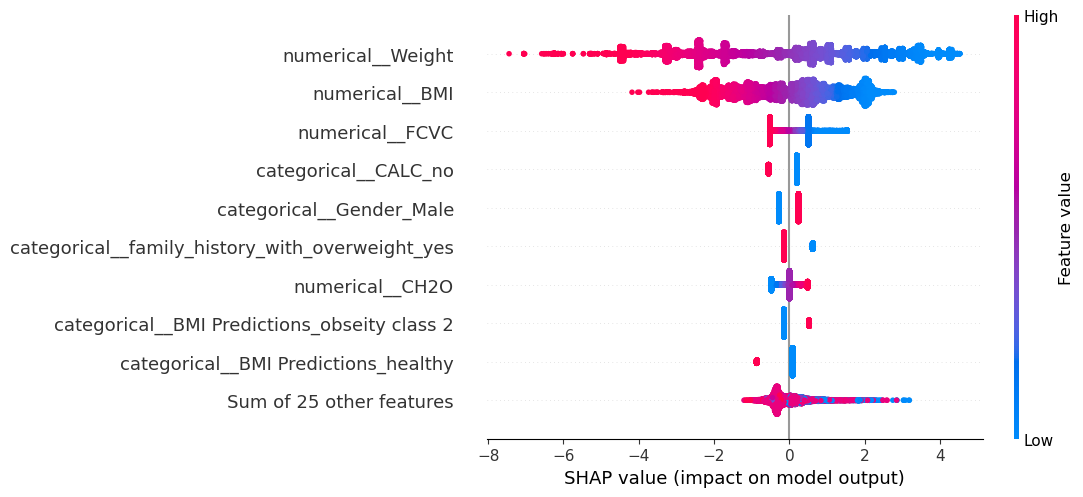

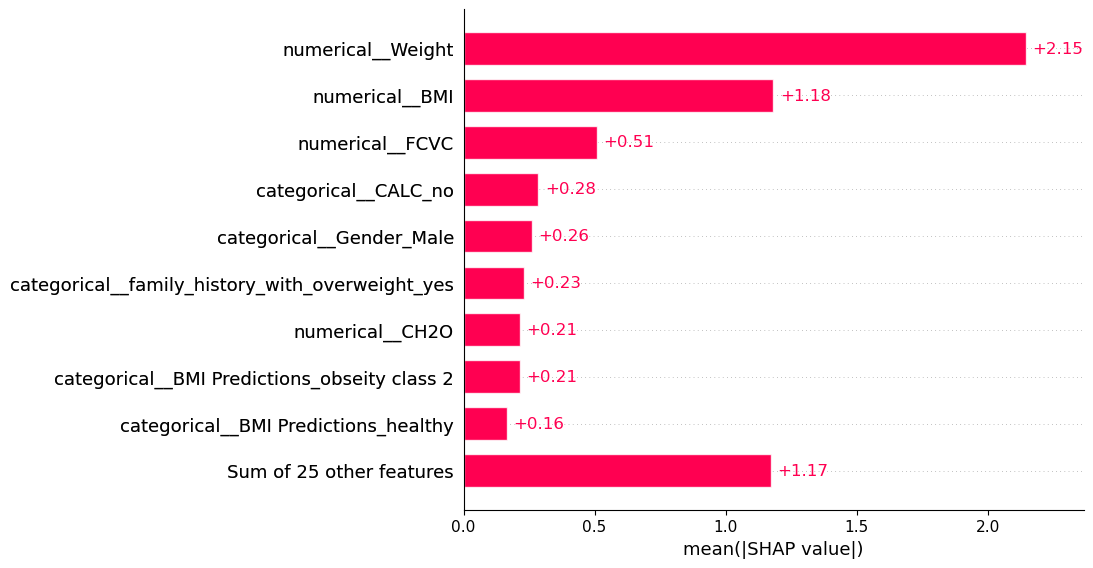

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


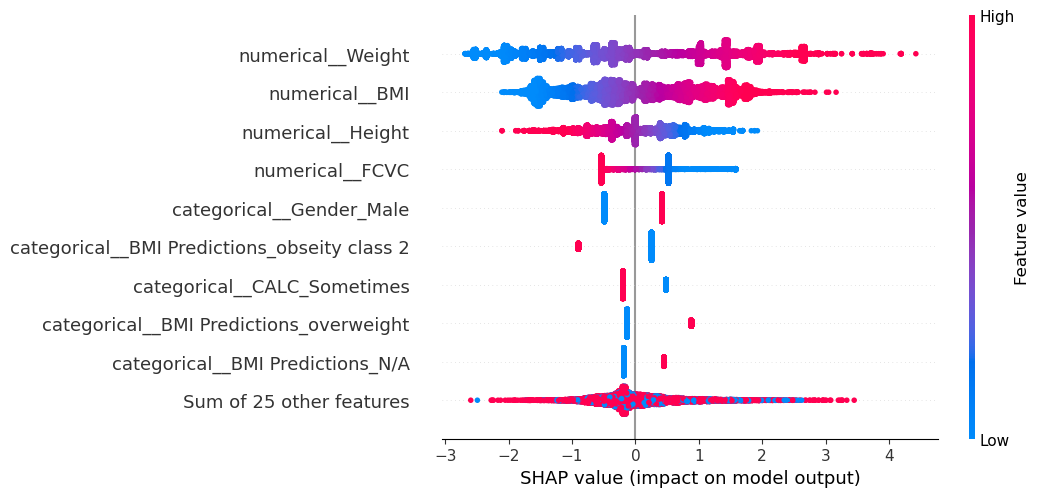

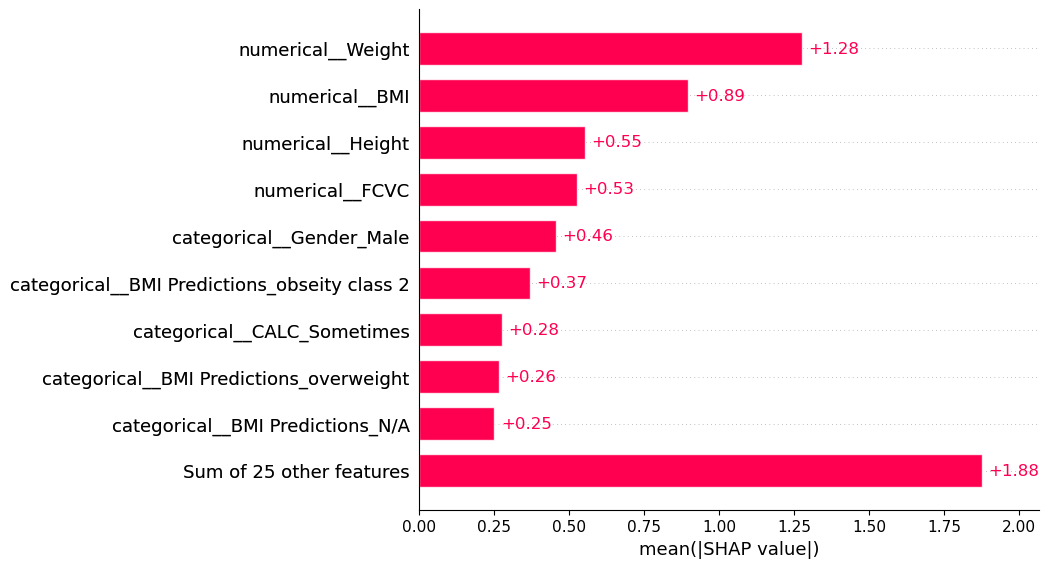

In [23]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.LinearExplainer(best_model, dataset)
shap_values = explainer(dataset)
print(shap_values.shape)

for i in range(shap_values.shape[2]):
    # summarize the effects of all the features
    shap.plots.beeswarm(shap_values[:, :, i])
    
    shap.plots.bar(shap_values[:, :, i])

In [24]:
# Model 2b - Logistic Regression w/ CV
# warnings.filterwarnings('ignore')

# test = []
# models = []
# for i, name in enumerate(preprocessed):
#     model = LogisticRegressionCV(max_iter = 1000)
#     train_results, test_results = train_and_evaluate_classifier(f"Logistic Regression CV {name}", model, X_train[i], y_train[i], X_test[i], y_test[i], confusion=False)
#     test.append(test_results[0])
#     print()
    
# test = np.array(test)
# loc_best_test = np.argmax(test)
# print(f"Best Preprocessing: {preprocessed[loc_best_test]} - Test Accuracy: {test[loc_best_test]}")
# best_model = models[loc_best_test]
# dataset = X_train[loc_best_test]

In [25]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
# explainer = shap.LinearExplainer(best_model, dataset)
# shap_values = explainer(dataset)
# print(shap_values.shape)

# for i in range(shap_values.shape[2]):
#     # summarize the effects of all the features
#     shap.plots.beeswarm(shap_values[:, :, i])
    
#     shap.plots.bar(shap_values[:, :, i])

In [26]:
# Model 3 - MLP
test = []
models = []
for i, name in enumerate(preprocessed):
    model = MLPClassifier(hidden_layer_sizes = (100,), solver='adam', max_iter=200, tol=1e-4, early_stopping=False, alpha=.0001)
    train_results, test_results = train_and_evaluate_classifier(f"MLP {name}", model, X_train[i], y_train[i], X_test[i], y_test[i], confusion=False, supress_outputs=False)
    test.append(test_results[0])
    models.append(model)
    print()
    
test = np.array(test)
loc_best_test = np.argmax(test)
print(f"Best Preprocessing: {preprocessed[loc_best_test]} - Test Accuracy: {test[loc_best_test]}")
best_model = models[loc_best_test]
dataset = X_train[loc_best_test]

MLP (Ordinal)
training time 3.945 s
predict time 0.012 s
Confusion matrix: 
TRAIN - Accuracy: 0.792166498048851, AUC_ROC_OVO: 0.9757018628445936, AUC_ROC_OVR: 0.978383562828575
TEST - Accuracy: 0.7754335260115607, AUC_ROC_OVO: 0.968346618231187, AUC_ROC_OVR: 0.9717157528101545

MLP (Ordinal Categorical Only - No Scaling)
training time 5.752 s
predict time 0.013 s
Confusion matrix: 
TRAIN - Accuracy: 0.8590836826130944, AUC_ROC_OVO: 0.9808456347570464, AUC_ROC_OVR: 0.9829253211139893
TEST - Accuracy: 0.8533236994219653, AUC_ROC_OVO: 0.9785020893916221, AUC_ROC_OVR: 0.9807921341052542

MLP (Ordinal Categorical Only - Standard Scaler)


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


training time 7.899 s
predict time 0.013 s
Confusion matrix: 
TRAIN - Accuracy: 0.9096690273160861, AUC_ROC_OVO: 0.9893816943870339, AUC_ROC_OVR: 0.9905377944451453
TEST - Accuracy: 0.8784682080924856, AUC_ROC_OVO: 0.9821147510702131, AUC_ROC_OVR: 0.9840049708941037

MLP (Ordinal Categorical Only - Robust Scaler)


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


training time 7.782 s
predict time 0.013 s
Confusion matrix: 
TRAIN - Accuracy: 0.9045382280676398, AUC_ROC_OVO: 0.9884535439395675, AUC_ROC_OVR: 0.9896334856741478
TEST - Accuracy: 0.8761560693641619, AUC_ROC_OVO: 0.981940174140923, AUC_ROC_OVR: 0.9837808769305034

MLP (One Hot Categorical Only - No Scaling)
training time 5.512 s
predict time 0.013 s
Confusion matrix: 
TRAIN - Accuracy: 0.8712241653418124, AUC_ROC_OVO: 0.9824746622641347, AUC_ROC_OVR: 0.9843844673211458
TEST - Accuracy: 0.8598265895953757, AUC_ROC_OVO: 0.9801433134081511, AUC_ROC_OVR: 0.9822423324270665

MLP (One Hot Categorical Only - Standard Scaler)


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


training time 8.413 s
predict time 0.014 s
Confusion matrix: 
TRAIN - Accuracy: 0.9192079780315074, AUC_ROC_OVO: 0.9913524434648544, AUC_ROC_OVR: 0.9922551015822644
TEST - Accuracy: 0.8765895953757226, AUC_ROC_OVO: 0.9820805830405341, AUC_ROC_OVR: 0.9839134947555385

MLP (One Hot Categorical Only - Robust Scaler)
training time 8.409 s
predict time 0.015 s
Confusion matrix: 
TRAIN - Accuracy: 0.9187021245844775, AUC_ROC_OVO: 0.9907696261347164, AUC_ROC_OVR: 0.9917765026075028
TEST - Accuracy: 0.8747109826589595, AUC_ROC_OVO: 0.981641070013009, AUC_ROC_OVR: 0.9835702940832854

Best Preprocessing: (Ordinal Categorical Only - Standard Scaler) - Test Accuracy: 0.8784682080924856


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


In [27]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
# explainer = shap.KernelExplainer(best_model.predict, dataset)
# shap_values = explainer(dataset)
# print(shap_values.shape)

# for i in range(shap_values.shape[2]):
#     # summarize the effects of all the features
#     shap.plots.beeswarm(shap_values[:, :, i])
    
#     shap.plots.bar(shap_values[:, :, i])

In [33]:
# Model 4 - KNN
test = []
models = []
for i, name in enumerate(preprocessed):
    model = KNeighborsClassifier()
    train_results, test_results = train_and_evaluate_classifier(f"KNN {name}", model, X_train[i].values, y_train[i], X_test[i].values, y_test[i], confusion=False)
    test.append(test_results[0])
    models.append(model)
    print()
    
test = np.array(test)
loc_best_test = np.argmax(test)
print(f"Best Preprocessing: {preprocessed[loc_best_test]} - Test Accuracy: {test[loc_best_test]}")
best_model = models[loc_best_test]
dataset = X_train[loc_best_test]

KNN (Ordinal)

KNN (Ordinal Categorical Only - No Scaling)

KNN (Ordinal Categorical Only - Standard Scaler)

KNN (Ordinal Categorical Only - Robust Scaler)

KNN (One Hot Categorical Only - No Scaling)

KNN (One Hot Categorical Only - Standard Scaler)

KNN (One Hot Categorical Only - Robust Scaler)

Best Preprocessing: (One Hot Categorical Only - No Scaling) - Test Accuracy: 0.875


In [42]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
# explainer = shap.Explainer(best_model)
# shap_values = explainer(dataset.values)
# print(shap_values.shape)

# for i in range(shap_values.shape[2]):
#     # summarize the effects of all the features
#     shap.plots.beeswarm(shap_values[:, :, i])
    
#     shap.plots.bar(shap_values[:, :, i])

In [43]:
# Model 5 - SVM
test = []
models = []
for i, name in enumerate(preprocessed):
    model = SVC(probability=True)
    train_results, test_results = train_and_evaluate_classifier(f"SVM {name}", model, X_train[i], y_train[i], X_test[i], y_test[i], confusion=False)
    test.append(test_results[0])
    models.append(model)
    print()
    
test = np.array(test)
loc_best_test = np.argmax(test)
print(f"Best Preprocessing: {preprocessed[loc_best_test]} - Test Accuracy: {test[loc_best_test]}")
best_model = models[loc_best_test]
dataset = X_train[loc_best_test]

SVM (Ordinal)

SVM (Ordinal Categorical Only - No Scaling)

SVM (Ordinal Categorical Only - Standard Scaler)

SVM (Ordinal Categorical Only - Robust Scaler)

SVM (One Hot Categorical Only - No Scaling)

SVM (One Hot Categorical Only - Standard Scaler)

SVM (One Hot Categorical Only - Robust Scaler)

Best Preprocessing: (One Hot Categorical Only - Standard Scaler) - Test Accuracy: 0.878757225433526


In [49]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
# explainer = shap.KernelExplainer(best_model.predict, dataset)
# shap_values = explainer(dataset)
# print(shap_values.shape)

# for i in range(shap_values.shape[2]):
#     # summarize the effects of all the features
#     shap.plots.beeswarm(shap_values[:, :, i])
    
#     shap.plots.bar(shap_values[:, :, i])

In [77]:
# Model 6a - LDA
test = []
models = []
for i, name in enumerate(preprocessed):
    model = LinearDiscriminantAnalysis()
    if sci.sparse.issparse(X_train[i]) == True:
        train_results, test_results = train_and_evaluate_classifier(f"LDA {name}", model, X_train[i].to_records(), y_train[i], X_test[i], y_test[i], confusion=False)
    else:
        train_results, test_results = train_and_evaluate_classifier(f"LDA {name}", model, X_train[i], y_train[i], X_test[i], y_test[i], confusion=False)
    test.append(test_results[0])
    models.append(model)
    print()
    
test = np.array(test)
loc_best_test = np.argmax(test)
print(f"Best Preprocessing: {preprocessed[loc_best_test]} - Test Accuracy: {test[loc_best_test]}")
best_model = models[loc_best_test]
dataset = X_train[loc_best_test]

LDA (Ordinal)

LDA (Ordinal Categorical Only - No Scaling)

LDA (Ordinal Categorical Only - Standard Scaler)

LDA (Ordinal Categorical Only - Robust Scaler)

LDA (One Hot Categorical Only - No Scaling)

LDA (One Hot Categorical Only - Standard Scaler)

LDA (One Hot Categorical Only - Robust Scaler)

Best Preprocessing: (Ordinal) - Test Accuracy: 0.8546242774566474


(13838, 19, 7)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


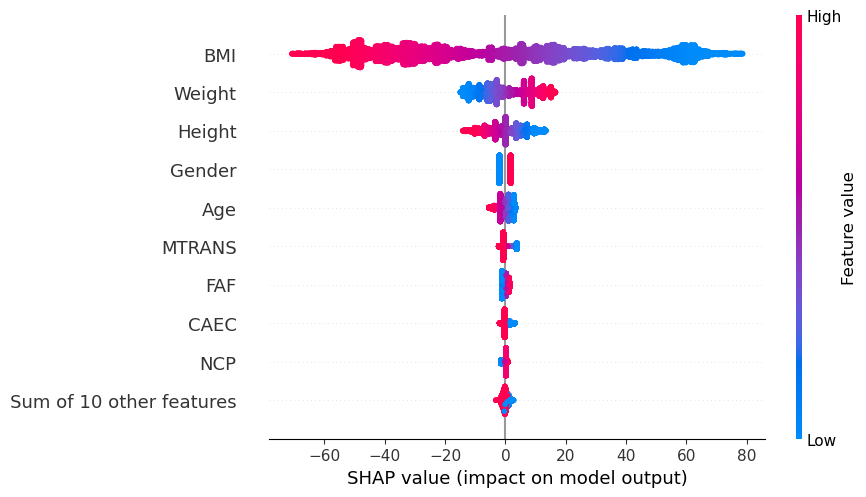

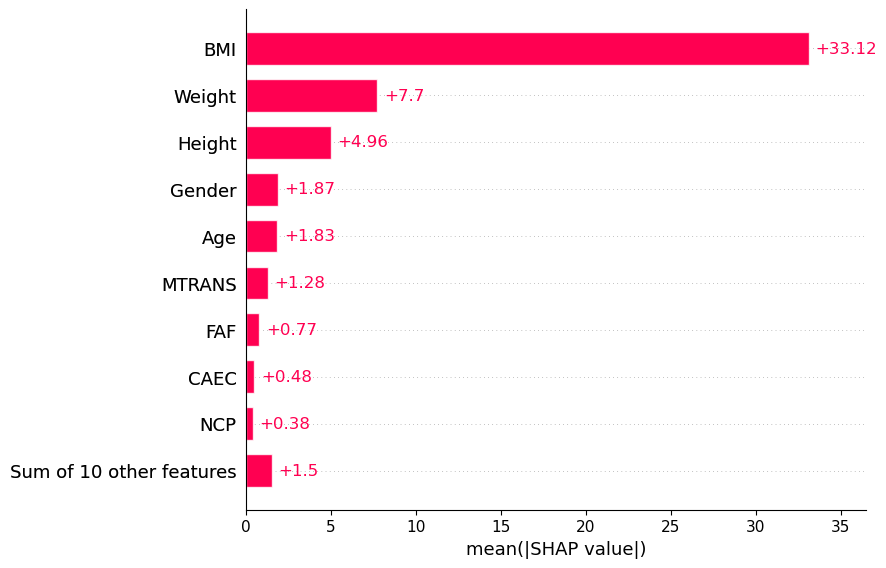

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


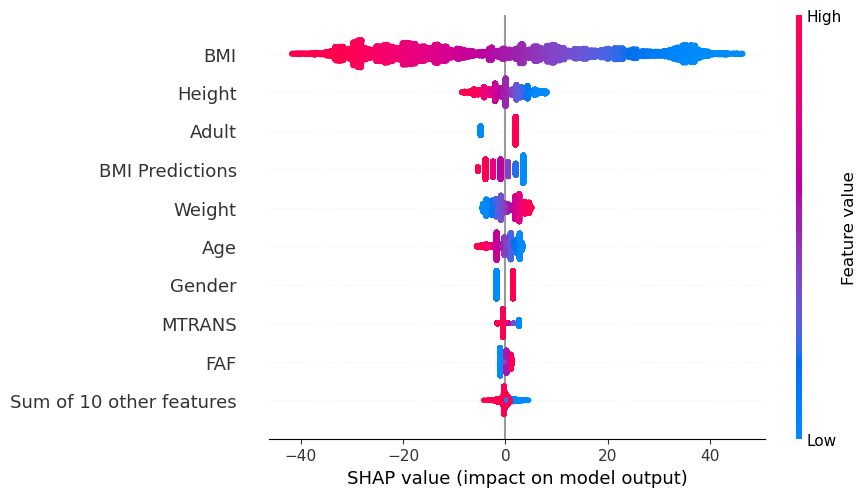

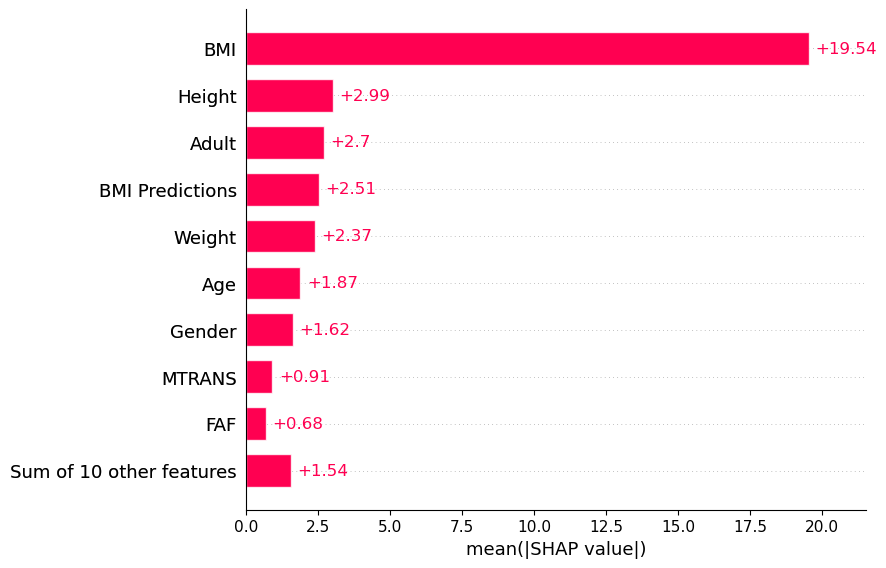

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


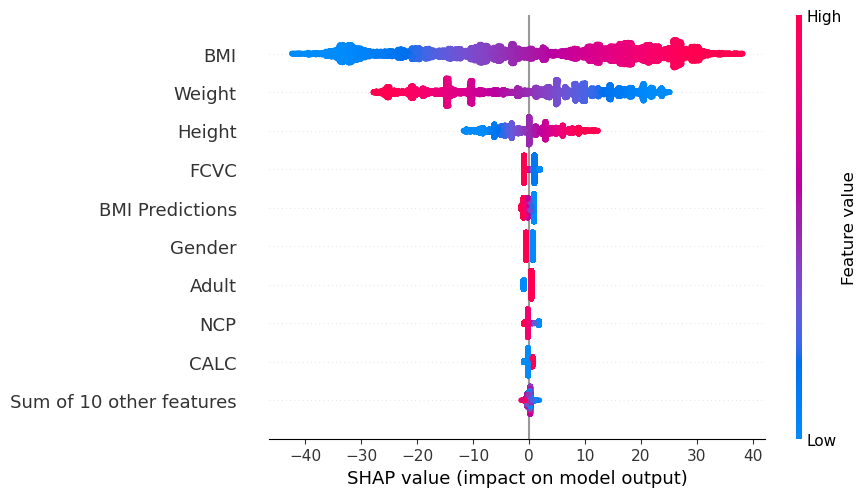

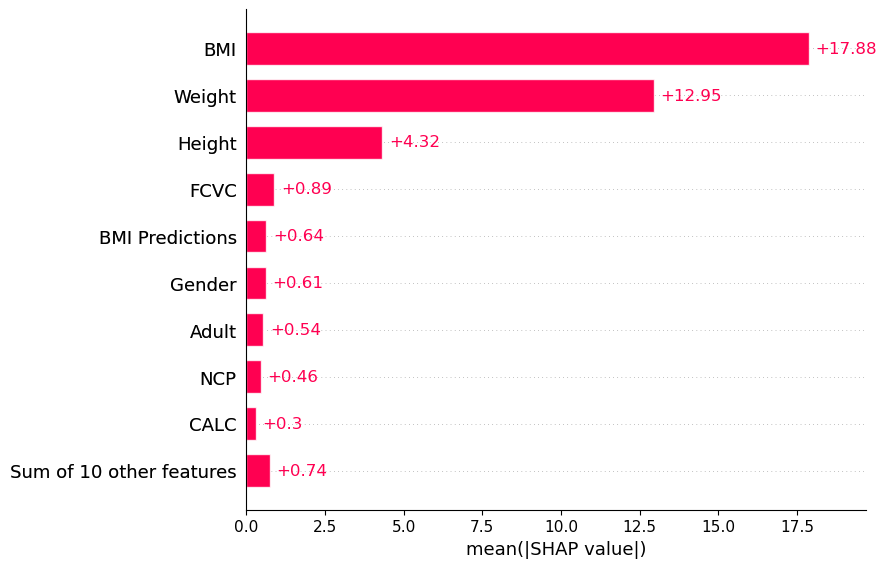

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


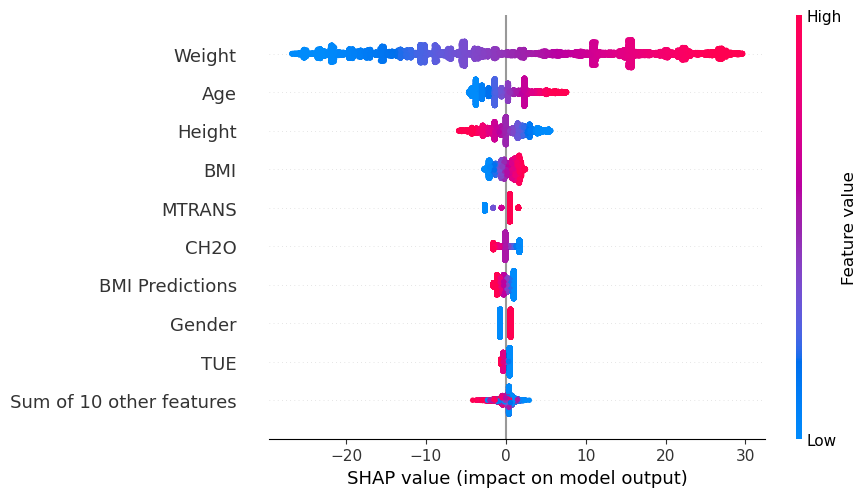

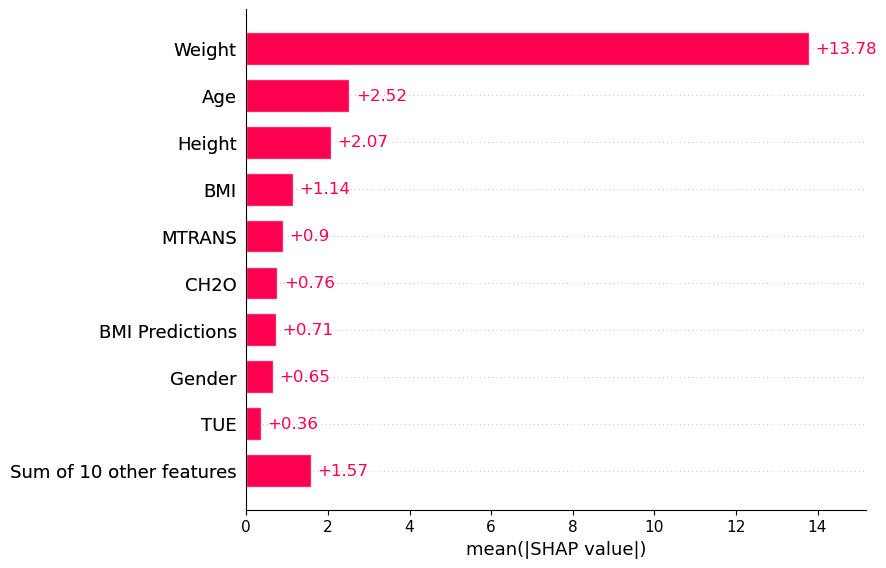

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


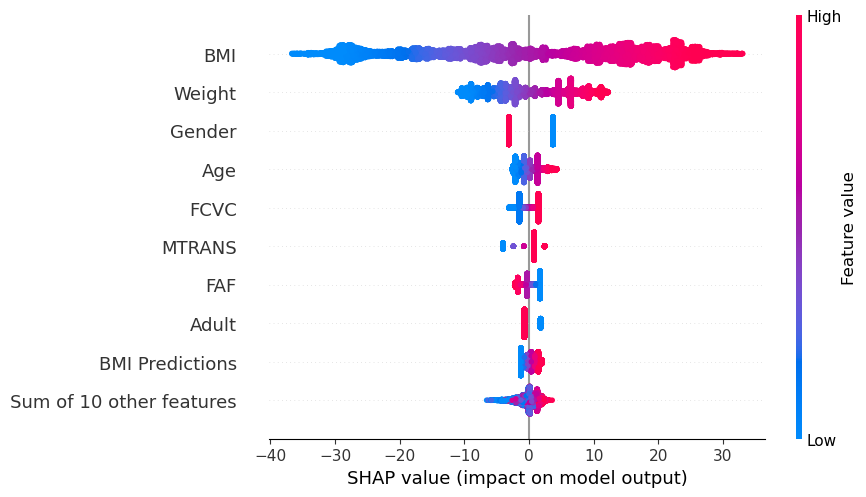

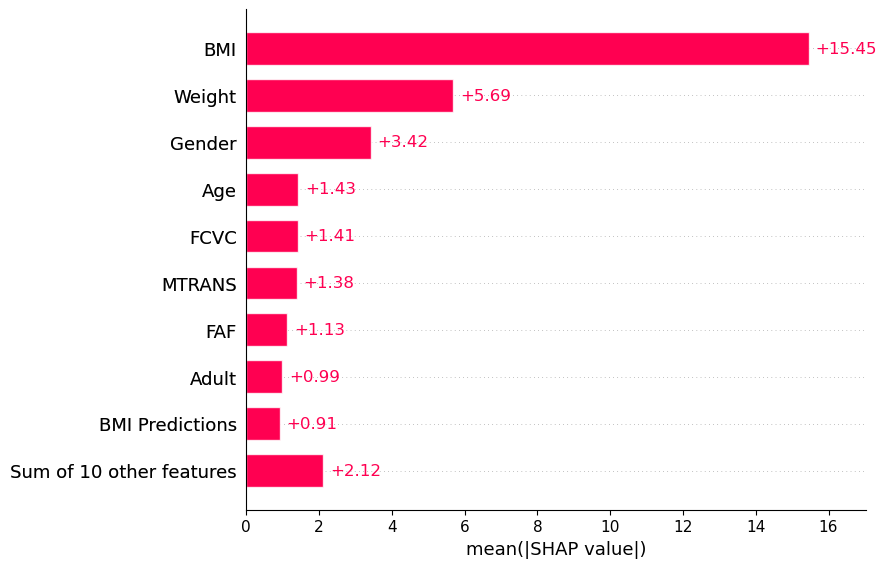

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


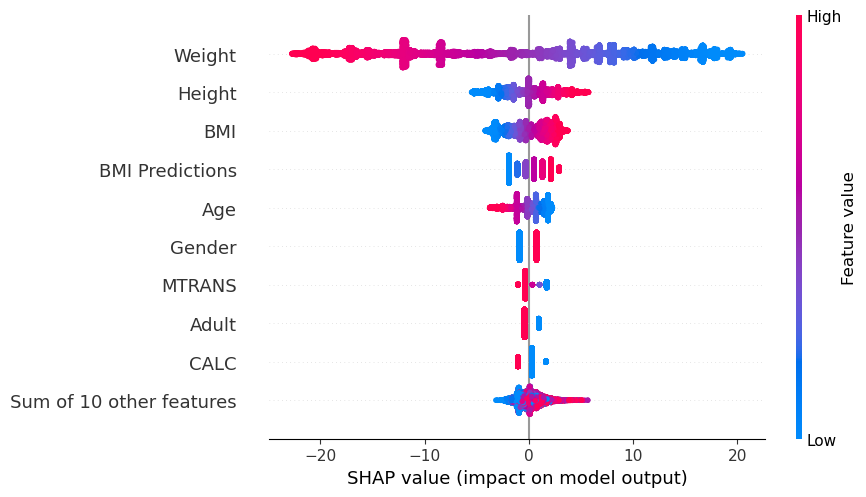

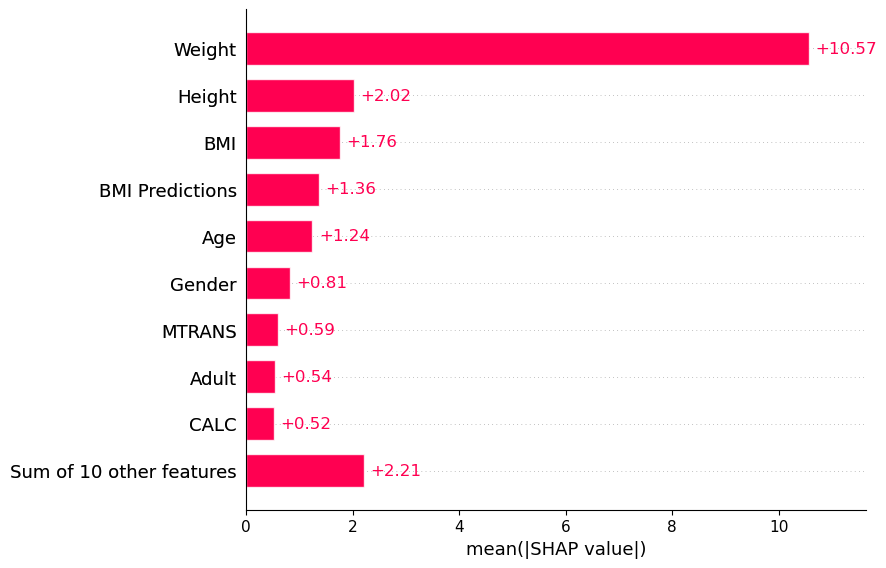

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


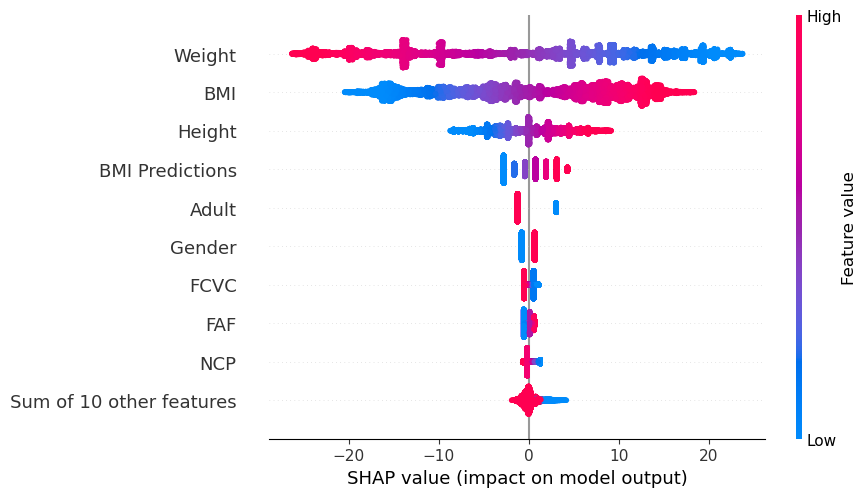

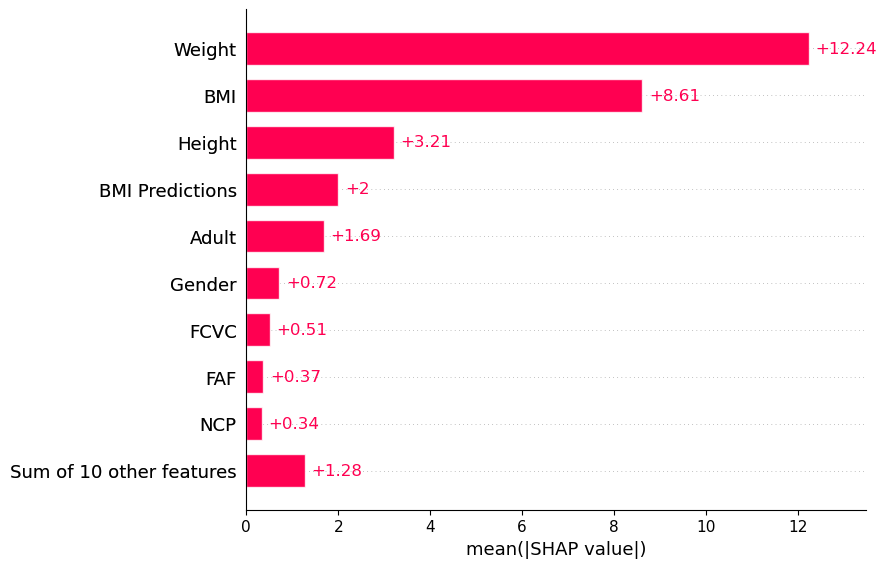

In [80]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.LinearExplainer(best_model, dataset)
shap_values = explainer(dataset)
print(shap_values.shape)

for i in range(shap_values.shape[2]):
    # summarize the effects of all the features
    shap.plots.beeswarm(shap_values[:, :, i])
    
    shap.plots.bar(shap_values[:, :, i])

In [56]:
# Model 6b - QDA
test = []
models = []
for i, name in enumerate(preprocessed):
    model = QuadraticDiscriminantAnalysis(reg_param=0.125)
    if sci.sparse.issparse(X_train[i]) or sci.sparse.issparse(X_test[i]) == True:
        train_results, test_results = train_and_evaluate_classifier(f"QDA {name}", model, X_train[i].values, y_train[i], X_test[i].values, y_test[i], confusion=False)
    else:
        train_results, test_results = train_and_evaluate_classifier(f"QDA {name}", model, X_train[i], y_train[i], X_test[i], y_test[i], confusion=False)
    test.append(test_results[0])
    models.append(model)
    print()
    
test = np.array(test)
loc_best_test = np.argmax(test)
print(f"Best Preprocessing: {preprocessed[loc_best_test]} - Test Accuracy: {test[loc_best_test]}")
best_model = models[loc_best_test]
dataset = X_train[loc_best_test]

QDA (Ordinal)


Variables are collinear



QDA (Ordinal Categorical Only - No Scaling)


Variables are collinear



QDA (Ordinal Categorical Only - Standard Scaler)


Variables are collinear



QDA (Ordinal Categorical Only - Robust Scaler)


Variables are collinear



QDA (One Hot Categorical Only - No Scaling)


Variables are collinear



QDA (One Hot Categorical Only - Standard Scaler)


Variables are collinear



QDA (One Hot Categorical Only - Robust Scaler)


Variables are collinear



Best Preprocessing: (Ordinal) - Test Accuracy: 0.8608381502890173


In [63]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
# explainer = shap.KernelExplainer(best_model.predict, dataset)
# shap_values = explainer(dataset.values)
# print(shap_values.shape)

# for i in range(shap_values.shape[2]):
#     # summarize the effects of all the features
#     shap.plots.beeswarm(shap_values[:, :, i])
    
#     shap.plots.bar(shap_values[:, :, i])

In [64]:
# Model 7a - Gaussian Naive Bayes
test = []
models = []
indexes = [0, 1, 2, 3, 4, 5, 6]
for i in indexes:
    name = preprocessed[i]
    model = GaussianNB()
    if sci.sparse.issparse(X_train[i]) or sci.sparse.issparse(X_test[i]) == True:
        train_results, test_results = train_and_evaluate_classifier(f"Gaussian Naive Bayes {name}", model, X_train[i].toarray(), y_train[i], X_test[i].toarray(), y_test[i], confusion=False)
    else:
        train_results, test_results = train_and_evaluate_classifier(f"Gaussian Naive Bayes {name}", model, X_train[i], y_train[i], X_test[i], y_test[i], confusion=False)
    test.append(test_results[0])
    models.append(model)
    print()
    
test = np.array(test)
loc_best_test = np.argmax(test)
print(f"Best Preprocessing: {preprocessed[loc_best_test]} - Test Accuracy: {test[loc_best_test]}")
best_model = models[loc_best_test]
dataset = X_train[loc_best_test]

Gaussian Naive Bayes (Ordinal)

Gaussian Naive Bayes (Ordinal Categorical Only - No Scaling)

Gaussian Naive Bayes (Ordinal Categorical Only - Standard Scaler)

Gaussian Naive Bayes (Ordinal Categorical Only - Robust Scaler)

Gaussian Naive Bayes (One Hot Categorical Only - No Scaling)

Gaussian Naive Bayes (One Hot Categorical Only - Standard Scaler)

Gaussian Naive Bayes (One Hot Categorical Only - Robust Scaler)

Best Preprocessing: (Ordinal) - Test Accuracy: 0.8062138728323699


In [67]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
# explainer = shap.KernelExplainer(best_model.predict, dataset)
# shap_values = explainer(dataset.values)
# print(shap_values.shape)

# for i in range(shap_values.shape[2]):
#     # summarize the effects of all the features
#     shap.plots.beeswarm(shap_values[:, :, i])
    
#     shap.plots.bar(shap_values[:, :, i])

Using 13838 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U19'), dtype('float64')) -> None

In [69]:
# Model 7e - Categorical Naive Bayes
test = []
indexes = [0, 1, 4]
for i in indexes:
    name = preprocessed[i]
    model = CategoricalNB()
    if sci.sparse.issparse(X_train[i]) or sci.sparse.issparse(X_test[i]) == True:
        train_results, test_results = train_and_evaluate_classifier(f"Categorical Naive Bayes {name}", model, X_train[i].toarray(), y_train[i], X_test[i].toarray(), y_test[i], confusion=False)
    else:
        train_results, test_results = train_and_evaluate_classifier(f"Categorical Naive Bayes {name}", model, X_train[i], y_train[i], X_test[i], y_test[i], confusion=False)
    test.append(test_results[0])
    models.append(model)
    print()
    
test = np.array(test)
loc_best_test = np.argmax(test)
print(f"Best Preprocessing: {preprocessed[indexes[loc_best_test]]} - Test Accuracy: {test[loc_best_test]}")
best_model = models[loc_best_test]
dataset = X_train[loc_best_test]

Categorical Naive Bayes (Ordinal)

Categorical Naive Bayes (Ordinal Categorical Only - No Scaling)

Categorical Naive Bayes (One Hot Categorical Only - No Scaling)

Best Preprocessing: (Ordinal Categorical Only - No Scaling) - Test Accuracy: 0.8725433526011561


In [76]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
# explainer = shap.KernelExplainer(best_model.predict, dataset.values)
# shap_values = explainer(dataset.values)
# print(shap_values.shape)

# for i in range(shap_values.shape[2]):
#     # summarize the effects of all the features
#     shap.plots.beeswarm(shap_values[:, :, i])
    
#     shap.plots.bar(shap_values[:, :, i])